In [2]:
import xnat
#xnat.__version__ # 0.3.21
print(f'XNATpy version = {xnat.__version__}') # 0.3.21
import SimpleITK as sitk
import pydicom
import dicom2nifti
import numpy as np
#import math
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import matplotlib.image as mpimg
import os, sys, time
import natsort
import dicom_functions
import explore_dicom_data
from myshow import myshow
import importlib

XNATpy version = 0.3.21


# Connect to XNAT server:

In [3]:
xnatAddress = 'http://10.1.1.17'

session = xnat.connect(xnatAddress, user='admin', password='admin')

# Define the REST path variables:

In [4]:
# Define selected project and subject labels, and session number:
projectLabel = 'BrainTumorProg'
subjectLabel = 'PGM-002'
experimentNo = 0 # (= 1 in XNAT web app; e.g. ‘PGM-002_MR_1’)
scanNo = 0 # 0 -> T1post

# Define the directory to download files from XNAT:

In [5]:
#downloadDir = r'C:\Users\ctorti\Documents\GitHub\WP1.3_multiple_modalities\trying stuff\XNAT downloads'
downloadDir = r'C:\Code\WP1.3_multiple_modalities\trying stuff\XNAT downloads'

# Create a sub-directory for this projectLabel:
newPath = os.path.join(downloadDir, projectLabel)
try:
    os.mkdir(newPath)
    print('Directory', projectLabel, 'created')
except FileExistsError:
    print('Directory', projectLabel, 'already exists')

# Create a sub-directory for this subjectLabel:
newPath = os.path.join(newPath, subjectLabel)
try:
    os.mkdir(newPath)
    print('Directory', subjectLabel, 'created')
except FileExistsError:
    print('Directory', subjectLabel, 'already exists')

# Create a sub-directory for this experimentNo:
newPath = os.path.join(newPath, str(experimentNo))
try:
    os.mkdir(newPath)
    print('Directory', experimentNo, 'created')
except FileExistsError:
    print('Directory', experimentNo, 'already exists')

# Crete a sub-directory for this scanNo:
newPath = os.path.join(newPath, str(scanNo))
try:
    os.mkdir(newPath)
    print('Directory', scanNo, 'created')
except FileExistsError:
    print('Directory', scanNo, 'already exists')
    
    
# Define location for plots to be exported to:
plotsDir = r'C:\Code\WP1.3_multiple_modalities\trying stuff\plots'

Directory BrainTumorProg already exists
Directory PGM-002 already exists
Directory 0 already exists
Directory 0 already exists


# Download the DICOM-RTStruct file to newPath:

In [6]:
# Download the DICOM-RTStruct file to newPath:
ROIobject = session.projects[projectLabel].subjects[subjectLabel].experiments[experimentNo].assessors[scanNo].resources[1]
ROIobject.download_dir(newPath)

779.9 KiB |#                                                      |  44.5 MiB/s


# Download the DICOM scans to newPath:

In [7]:
# Download the DICOM scans to newPath:
session.projects[projectLabel].subjects[subjectLabel].experiments[experimentNo].scans[0].download_dir(newPath)

 11.9 MiB | #                                                     |  60.5 MiB/s


# Define the paths to the exported DICOM and DICOM-RTStruct files:

In [8]:
# The DICOM files were exported here:
dicomsPath = r'C:\Users\ctorti\Documents\GitHub\WP1.3_multiple_modalities\trying stuff\XNAT downloads\BrainTumorProg\PGM-002\0\0\PGM-002_MR_1\scans\11-T1post\resources\DICOM\files'

# And the ROI DICOM-RTStruct file was exported here:
roiPath = r'C:\Users\ctorti\Documents\GitHub\WP1.3_multiple_modalities\trying stuff\XNAT downloads\BrainTumorProg\PGM-002\0\0\AIM_20200123_145716\out\resources\RTSTRUCT\files'

# Get the filepaths of the DICOM scans:

In [9]:
dicomsFpaths = dicom_functions.dc_filepaths(dicomsPath)
#list(dicomsFpaths)

# Create a dictionary dicomsDict to store the pixel array, image origin, and pixel spacing, using the UIDs as keys:

In [10]:
dicomsDict = dict()

for f in range(len(dicomsFpaths)):
    fpath = dicomsFpaths[f]
    dicom = pydicom.read_file(fpath)
    uid = dicom.SOPInstanceUID
    #position = float(dicom.ImagePositionPatient) # TypeError: float() argument must be a string or a number, not 'MultiValue'
    position = np.array(dicom.ImagePositionPatient).astype(np.float)
    orientation = np.array(dicom.ImageOrientationPatient).astype(np.float)
    pixSpacing = np.array(dicom.PixelSpacing).astype(np.float)
    pixelArray = dicom.pixel_array

    dicomsDict[uid] = {'Frame number':f+1, \
                       'Position':position, \
                       'Orientation':orientation, \
                       'Pixel spacing':pixSpacing, \
                       'Pixel array':pixelArray
                      }

#dicomsDict

# Load the DICOM-RTStruct file:

In [11]:
# Load the DICOM-RTStruct file:
roi = explore_dicom_data.load_dicoms_natsort(roiPath)

# Because the load_dicoms_natsort() function stored the DICOM in a numpy array, need to index the first element:
roi = roi[0]

#roi

# Create a dictionary contoursDict to store the contour data and number of contour points, using the UIDs as keys:

In [12]:
# Since the contour number, number of contour points and the contour data elements are all strings,
# convert the contour number and number of contour points to integers, and store the contour data
# array as a numpy array so it can easily be converted to float:

contoursDict = dict()

# For any given UID...
# count the number of contours:
# Ncontours = 0 # initial value
# create a list of the contour number(s):
# contourNo = [] 
# create a list of the number of contour points:
# NcontourPts = []
# create a list of contour data:
# contourData = []

# Loop for each contour sequence:
for sequence in roi.ROIContourSequence[0].ContourSequence:
    uid = sequence.ContourImageSequence[0].ReferencedSOPInstanceUID
    
    # Get the keys (UIDs) in contoursDict so far:
    keys = list(contoursDict.keys())
    
    # Check if this uid is in keys. If it isn't this is the first time
    # for this uid.  Initialise the values:
    if uid not in keys:
        Ncontours = 0
        contourNo = [] 
        NcontourPts = []
        contourData = []
        
    # Append the values for this sequence:
    Ncontours = Ncontours + 1 # increment
    contourNo.append(int(sequence.ContourNumber))
    NcontourPts.append(int(sequence.NumberOfContourPoints))
    contourData.append(np.array(sequence.ContourData).astype(np.float))
     
    # Store the values for this uid. Values will be over-written if there's more than
    # one contour for this uid, but the lists have been appended already:
    contoursDict[uid] = {'Number of contours':Ncontours, \
                         'Contour number':contourNo, \
                         'Number of contour points':NcontourPts, \
                         'Contour data':contourData
                        }
    
#contoursDict

# Combine contoursDict and dicomsDict into a new dictionary called dataDict:

In [13]:
Ckeys = list(contoursDict.keys())
Dkeys = list(dicomsDict.keys())

# Create a new dictionary called dataDict that combines both dictionaries. 
# Start by copying dicomsDict:
dataDict = dicomsDict.copy()

for Dkey in Dkeys: # cycle through each key in dicomsDict
    # Check if Dkey is in Ckeys:
    if Dkey in Ckeys:
        # There is contour data for this Dkey, so update dataDict[Dkey]
        # with contoursDict[Ckey]:
        ind = Ckeys.index(Dkey) # find index of matching key in contoursDict
        dataDict[Dkey].update(contoursDict[Dkey]) # Note: Dkey=Ckey
    
    else:
        # There is no contour data for this Dkey, so fill in the missing
        # values:
        dataDict[Dkey].update({'Number of contours':0, \
                              'Contour number':[], \
                              'Number of contour points':0, \
                              'Contour data':[]
                              })

#dataDict

# Create a new array "contourPts" containing the (x,y) image coordinates of each contour point and save it in dataDict:

In [14]:
# Conversion of contour points from patient coordinates to image coordinates
# adapted from James Petts' (ICR) Java code: 

for uid, values in dataDict.items():
    # Get the values for this uid:
    # Note that for any given uid, NcontourPts and contourData could
    # be lists of values, if multiple contours existed for that uid.  
    # Even if there was only one contour, the single value (or single 
    # list) will be enclosed in [].
    position = values['Position'] # e.g. [x, y, z]
    orientation = values['Orientation'] # e.g. [row_x, row_y, row_z, col_x, col_y, col_z]
    pixSpacing = values['Pixel spacing'] # e.g. [dx, dy]
    Ncontours = values['Number of contours'] # e.g. 1 or 2, etc.
    #contourNo = values['Contour number'] # e.g. [4] or [4, 5], etc.
    #NcontourPts = values['Number of contour points'] # e.g. [200] or [200, 300], etc.
    contourData = values['Contour data'] # e.g. [[x1,y1,z1,...]] or [[x1,y1,z1,...], [x1,y1,z1,...]], etc.

    # The patient coordinates:
    x0 = position[0]
    y0 = position[1]
    z0 = position[2]
    
    # The direction cosines along rows and columns:
    #row_x, row_y, row_z, col_x, col_y, col_z = orientation
    row = orientation[0:3]
    col = orientation[3:6]
    
    # The indeces of the largest direction cosines along rows and columns:
    rowMaxInd = np.where(row==max(row))[0][0]
    colMaxInd = np.where(col==max(col))[0][0]
    
    # The pixel spacings:
    dx = pixSpacing[0]
    dy = pixSpacing[1]
    
    # Create an array of (x,y) points from the flattened contour data:
    contourPts = []
    
    # Iterate for each contour for this uid:
    for c in range(Ncontours):
        # Also store the contour points for each contour within any given uid:
        contourPts_c = []
    
        # Iterate for all countour points in threes:
        #for i in range(0, NcontourPts, 3): # this would need to be range(0, 3*NcontourPts, 3)!!
        for p in range(0, len(contourData[c]), 3):
            # Define vector v as the the patient position subtracted from the contour coordinates:
            v = contourData[c][p] - x0, contourData[c][p+1] - y0, contourData[c][p+2] - z0
            
            # Convert from patient coord system to image coord system:          
            i = (v[rowMaxInd] - col[rowMaxInd]*v[colMaxInd]/col[colMaxInd]) / \
            (row[rowMaxInd]*dx * (1 - (col[rowMaxInd]*row[colMaxInd])/(row[rowMaxInd]*col[colMaxInd])))
            
            j = (v[colMaxInd] - row[colMaxInd]*i*dx) / (col[colMaxInd]*dy)

            contourPts_c.append([i,j])
            
        # Append contourPts with contourPts_c:
        contourPts.append(contourPts_c)

    # Add contourPts to dictData for this uid (key):
    dataDict[uid].update({'Contour points':contourPts})

#dataDict

# Plot the DICOM scans with contours overlayed:

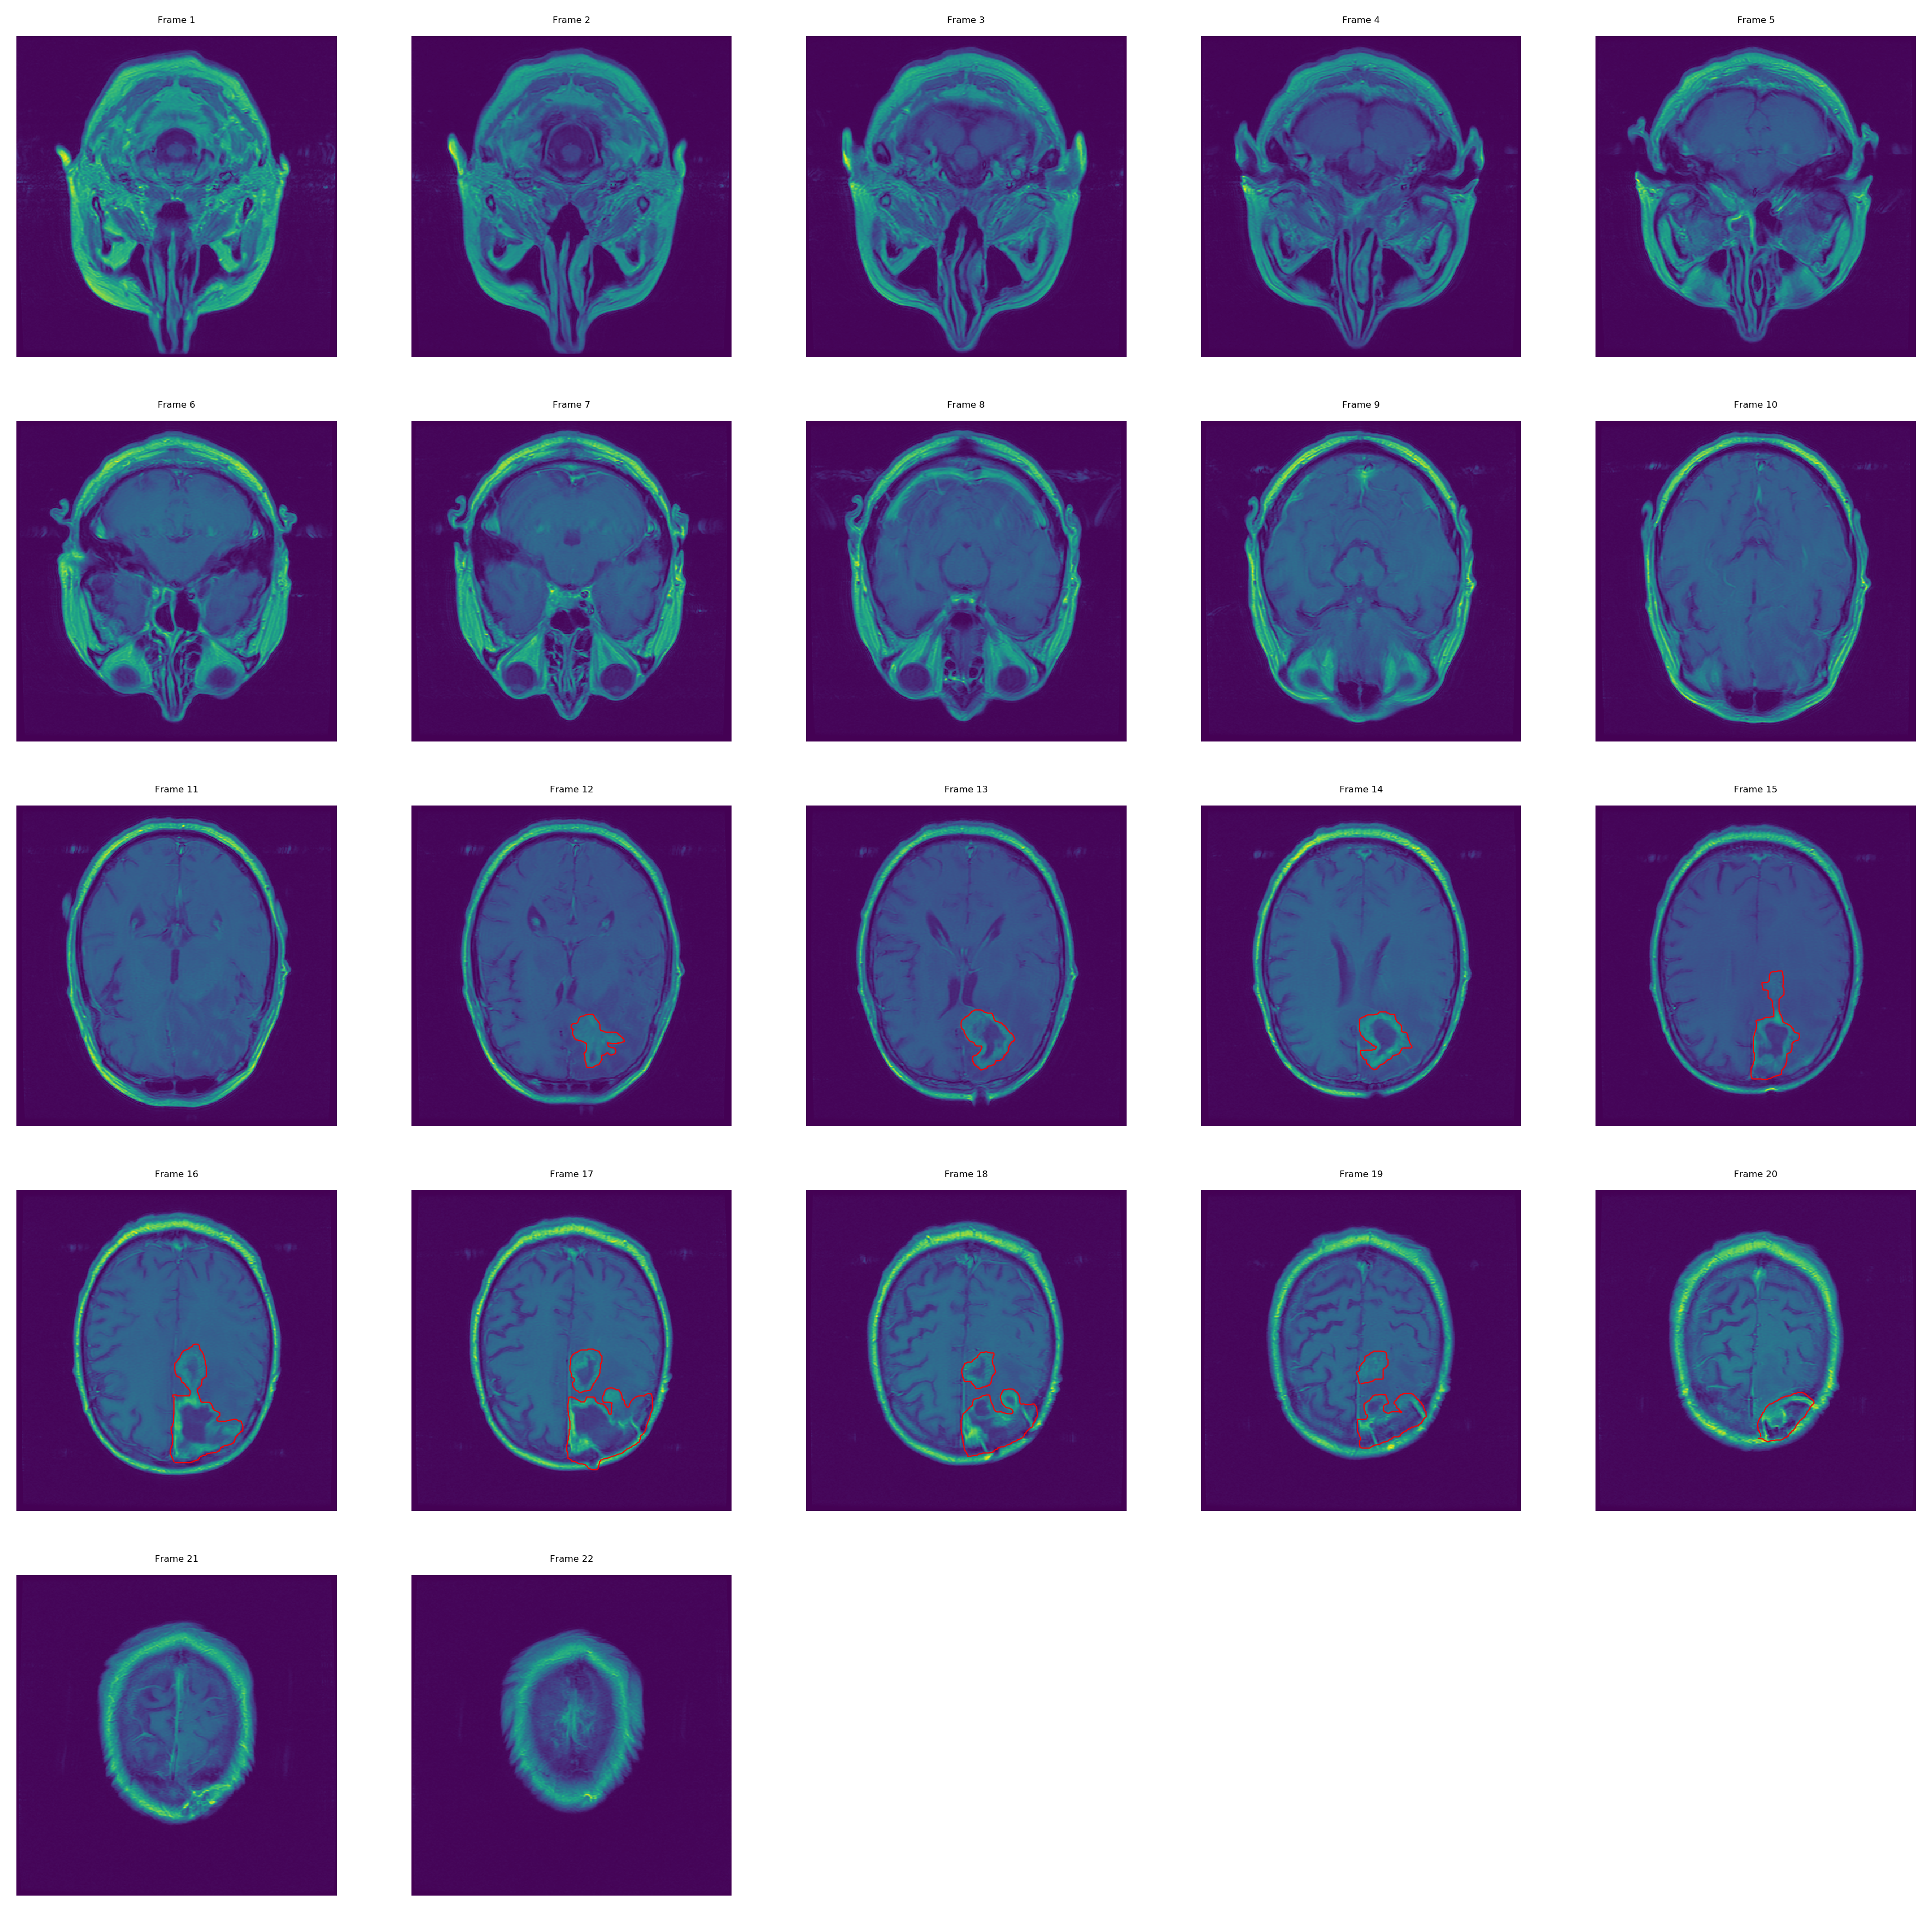

In [15]:
# Configure plot:

# Set the title font:
fontSize=4

Nuids = len(dataDict.keys())

# Set the number of subplot rows and columns:
rows = np.int8(np.round(np.sqrt(Nuids)))
cols = np.int8(np.round(np.sqrt(Nuids)))

plt.figure(figsize=(15,15), dpi=300);

i = 0 # for subplot pos

for uid, values in dataDict.items(): 
    frameNo = values['Frame number']
    pixArray = values['Pixel array']
    Ncontours = values['Number of contours']
    contourPts = values['Contour points']
    
    # Plot the pixel array:
    i = i + 1    
    plt.subplot(rows,cols,i, aspect='equal')
    plt.pcolormesh(pixArray);
    plt.title(f'Frame {frameNo}', size=fontSize);
    plt.axis('off');
    
    # Plot the contours:
    if Ncontours > 0:   
        for c in range(Ncontours):
            # Unpack tuple and store each x,y tuple in arrays xList and yList:
            xList = []
            yList = []
            for x, y in contourPts[c]:
                xList.append(x)
                yList.append(y)

            # Create 2D arrays for the X and Y values using meshgrid:
            #X, Y = np.meshgrid(xList, yList)
            X = xList[:]
            Y = yList[:]

            plt.plot(X, Y, linewidth=0.5, c='red');


seriesDescription = dicom.SeriesDescription

exportFname = projectLabel + ' ' + subjectLabel + ' ' + seriesDescription \
+ ' All frames with ROIs using XNATpy.jpg'

exportFpath = os.path.join(plotsDir, exportFname)

#plt.savefig(exportFpath, bbox_inches='tight')